In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.stats import kurtosis
import scipy.stats as stats
from sklearn import preprocessing
from itertools import combinations
import warnings
import pandas as pd
from sklearn import metrics
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.pipeline import Pipeline
from category_encoders.woe import WOEEncoder
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
warnings.filterwarnings("ignore")


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv


In [2]:
#importing dataset
data = pd.read_csv('/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv')
data_copy = data.copy()

In [3]:
data_copy.shape

(32581, 12)

In [4]:
data_copy.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# Train Test split before pre-processing

In [5]:
data_copy.duplicated().sum()

165

In [6]:
#remove duplicate
data_copy = data_copy.drop_duplicates()
data_copy.reset_index(drop=True, inplace=True)
data_copy.duplicated().sum()

0

In [7]:
data_copy.shape

(32416, 12)

In [8]:
y = data_copy.pop("loan_status")
X = data_copy

In [9]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.3)

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((22691, 11), (22691,), (9725, 11), (9725,))

# Feature engineering

1. drop duplicate
2. impute missing
3. process outliers (robust scaler)
4. encode categorical data

In [11]:
X_train.duplicated().sum(), X_test.duplicated().sum()

(0, 0)

In [12]:
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt','loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_cols = ['person_home_ownership', 'loan_intent','loan_grade','cb_person_default_on_file']

In [13]:
#feature engineering for numerical data
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(missing_values=np.nan, strategy='median')), 
           ("scaler", RobustScaler())]
)

#feature engineering for categorical data
cat_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

In [14]:
#full training feature engineering
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, numerical_cols),
        ("cat", cat_transformer, categorical_cols),
    ]
)


# Model

In [15]:
#full training pipline
clf_logReg = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf_svm = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", svm.SVC(probability=True))]
)


In [16]:
clf_logReg.fit(X_train, y_train)
clf_svm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat',
                                                  Pipeline(steps=[(

In [17]:
y_pred = clf_logReg.predict(X_test)
print(f"Accuracy score logistic regression {accuracy_score(list(y_test), list(y_pred))}")

y_pred = clf_svm.predict(X_test)
print(f"Accuracy score svm {accuracy_score(list(y_test), list(y_pred))}")

Accuracy score logistic regression 0.8648843187660669
Accuracy score svm 0.912904884318766


In [18]:
def plot_roc_curve(model, X_test, y_test):
    y_pred_prob_test = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thres = metrics.roc_curve(y_test, y_pred_prob_test)
    roc_auc = metrics.auc(fpr, tpr)
    plt.figure(figsize = (10, 8))
    plt.plot(fpr, tpr, 'b-', color='darkorange', lw=2, linestyle='--', label='ROC curve (area = %0.2f)'%roc_auc)
    plt.plot([0, 1], [0, 1], '--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.title('ROC Curve')

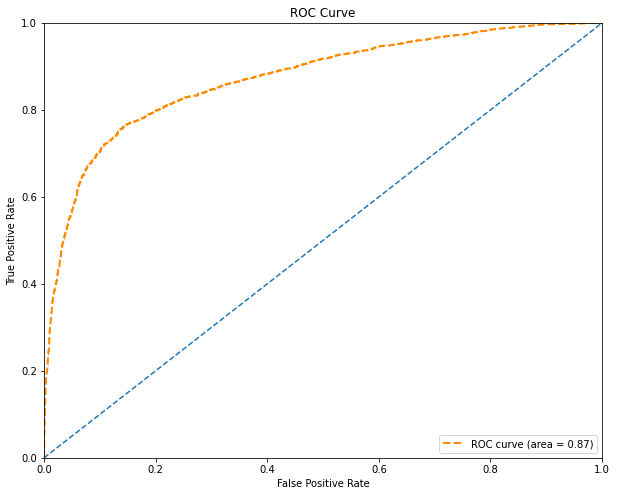

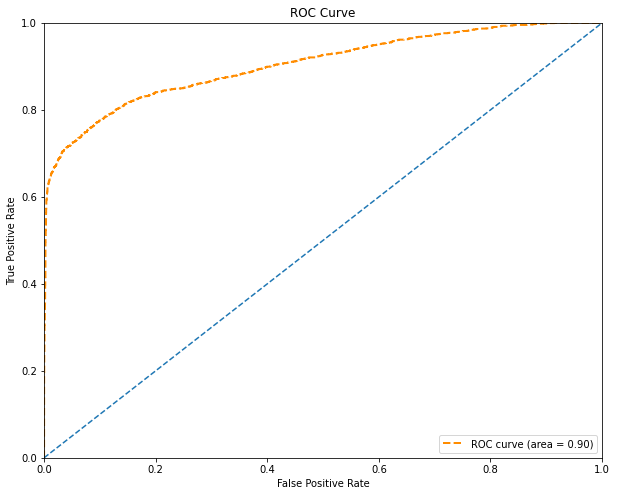

In [19]:
plot_roc_curve(clf_logReg, X_test, y_test)
plot_roc_curve(clf_svm, X_test, y_test)

# Using weight of evidence encoder

In [20]:
data_woe = data.copy()

In [21]:
#remove duplicate
data_woe = data_woe.drop_duplicates()
data_woe.reset_index(drop=True, inplace=True)
data_woe.duplicated().sum()

0

In [22]:
#fill missing value
data_woe["person_emp_length"] = data_woe["person_emp_length"].fillna(data_woe["person_emp_length"].median())
data_woe["loan_int_rate"] = data_woe["loan_int_rate"].fillna(data_woe["loan_int_rate"].median())

In [23]:
#train test split
y_woe = data_woe.pop("loan_status")
X_woe = data_woe
X_train_woe, X_test_woe, y_train_woe, y_test_woe = train_test_split(X_woe, y_woe, random_state=42, test_size=0.3)

In [24]:
X_train_woe.shape, X_test_woe.shape, y_train_woe.shape, y_test_woe.shape

((22691, 11), (9725, 11), (22691,), (9725,))

**WOEEncoder**

In [25]:
for col in categorical_cols + numerical_cols:
    woe=WOEEncoder(cols=[col])
        
    X_train_woe['woe_'+col]=woe.fit_transform(X_train_woe[col],y_train_woe)
    X_test_woe['woe_'+col]=woe.transform(X_test_woe[col])

In [26]:
woe_cols = list(X_train_woe.columns)[-11:]
woe_cols

['woe_person_home_ownership',
 'woe_loan_intent',
 'woe_loan_grade',
 'woe_cb_person_default_on_file',
 'woe_person_age',
 'woe_person_income',
 'woe_person_emp_length',
 'woe_loan_amnt',
 'woe_loan_int_rate',
 'woe_loan_percent_income',
 'woe_cb_person_cred_hist_length']

In [27]:
X_train_woe[["loan_int_rate","woe_loan_int_rate"]]

,loan_int_rate,woe_loan_int_rate
30316,15.68,1.791422
7763,11.34,0.230774
25942,12.87,0.038090
11309,8.94,-0.505193
15963,16.95,2.579879
...,...,...
29802,10.99,-0.123826
5390,6.92,-0.963149
860,17.99,2.167899
15795,10.99,-0.123826


In [28]:
clf_logReg_woe = LogisticRegression(random_state=42).fit(X_train_woe[woe_cols[-11:]], y_train_woe)
clf_svm_woe = svm.SVC(probability=True).fit(X_train_woe[woe_cols[-11:]], y_train_woe)

In [29]:
y_pre_logReg_woe = clf_logReg_woe.predict(X_test_woe[woe_cols[-11:]])
y_pre_svm_woe = clf_svm_woe.predict(X_test_woe[woe_cols[-11:]])

In [30]:
print(f"Accuracy score logistic regression {accuracy_score(list(y_test_woe), list(y_pre_logReg_woe))}")
print(f"Accuracy score svm {accuracy_score(list(y_test_woe), list(y_pre_svm_woe))}")

Accuracy score logistic regression 0.8930591259640103
Accuracy score svm 0.9204113110539845


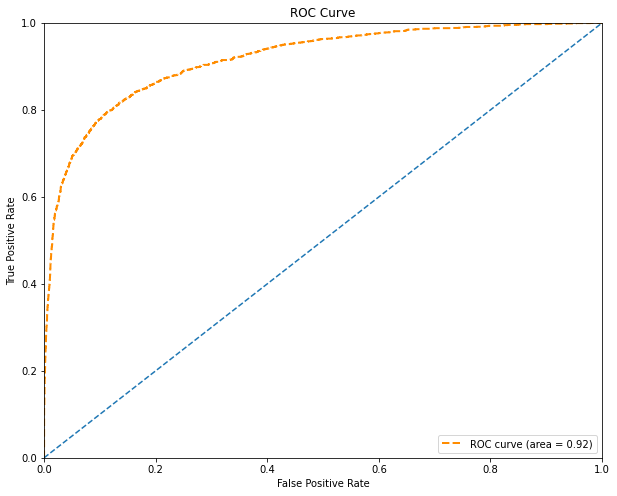

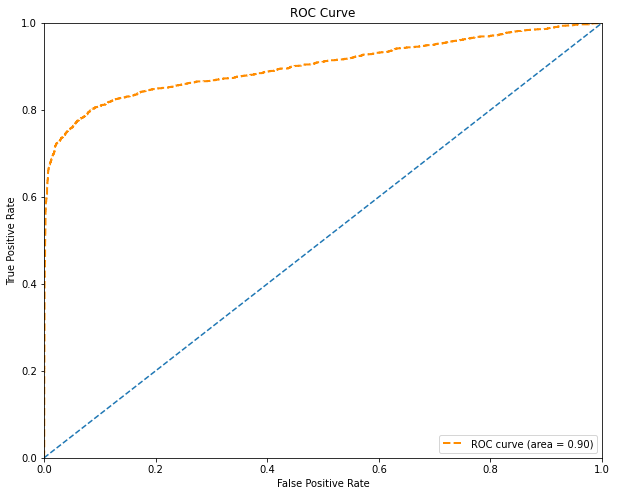

In [31]:
from sklearn.metrics import roc_curve, auc


plot_roc_curve(clf_logReg_woe, X_test_woe[woe_cols[-11:]], y_test_woe)
plot_roc_curve(clf_svm_woe, X_test_woe[woe_cols[-11:]], y_test_woe)